In [1]:
import os,sys,time
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import copy

from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from datetime import datetime

_dtype_ = torch.float32
_device_ = torch.device("cpu")

class PP_MLP(nn.Module): # Price Pridiction

    def __init__(self, init_method = 'uniform'):

        super(PP_MLP, self).__init__()
        self.layer1 = nn.Linear(14, 10)  
        self.layer2 = nn.Linear(10, 5)
        self.layer3 = nn.Linear(5, 3)
        self.output = nn.Linear(3, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.relu(self.layer1(x)) 
        x = self.relu(self.layer2(x)) 
        x = self.relu(self.layer3(x)) 
        return self.output(x) 
    
class PP_LSTM(nn.Module):
    def __init__(self, init_method='uniform'):

        super(PP_LSTM, self).__init__()
        self.hidden_dim = 10
        self.lstm = nn.LSTM(14, self.hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.dense_1 = nn.Linear(self.hidden_dim, 5)
        self.dense_2 = nn.Linear(5, 3)
        self.dense_3 = nn.Linear(3, 1)
        self.relu = nn.ReLU()

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        
        x = lstm_out[:, -1, :]
        x = self.dropout(x) 
        x = self.relu(self.dense_1(x))
        x = self.dropout(x) 
        x = self.relu(self.dense_2(x))
        x = self.dropout(x) 
        x = self.dense_3(x)
        
        return x
        
        
class H5Dataset(Dataset):
    def __init__(self, file_path, norm_flag):
        self.file_path = file_path
        self.dataset = {}

        with h5py.File(self.file_path, 'r') as file:
            self.dataset['inputs'] = file['inputs'][:]
            self.dataset['outputs'] = file['outputs'][:]

        if norm_flag == 'n':
            self.normalization()
        if norm_flag == 'd':
            pass
    
    def __len__(self):
        return len(self.dataset['inputs'])

    def __getitem__(self, idx):
        input_data = torch.tensor(self.dataset['inputs'][idx], dtype=torch.float32)
        output_data = torch.tensor(self.dataset['outputs'][idx], dtype=torch.float32)
        return input_data, output_data
    
    def normalization(self):
        inputs = self.dataset['inputs']
        outputs = self.dataset['outputs']
        min_vals_i = inputs.min(axis=0)  
        max_vals_i = inputs.max(axis=0) 
        min_vals_o = outputs.min(axis=0)  
        max_vals_o = outputs.max(axis=0)         

        ranges_i = max_vals_i - min_vals_i
        ranges_i[ranges_i == 0] = 1

        if (max_vals_o - min_vals_o)!= 0:
            ranges_o = max_vals_o - min_vals_o
        else:
            ranges_o = 1

        self.dataset['inputs'] = (inputs - min_vals_i) / ranges_i
        self.dataset['outputs'] = ((outputs - min_vals_o) / ranges_o).squeeze()

def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [2]:
dataset_train = H5Dataset('../data/lob_data/lob_data_train.h5','n')
dataset_train_dn = H5Dataset('../data/lob_data/lob_data_train.h5','d')

dataset_verif = H5Dataset('../data/lob_data/lob_data_verif.h5','n')
dataset_verif_dn = H5Dataset('../data/lob_data/lob_data_verif.h5','d')

dataset_test = H5Dataset('../data/lob_data/lob_data_test.h5','n')
dataset_test_dn = H5Dataset('../data/lob_data/lob_data_test.h5','d')

In [4]:
PPMLP_model = PP_MLP(init_method = 'uniform').to(_device_)

loader_train = DataLoader(dataset_train, batch_size=4096, shuffle = True)
loader_verif = DataLoader(dataset_verif, batch_size=4096, shuffle = True)

criterion = nn.MSELoss()
optimizer = optim.Adam(PPMLP_model.parameters(), lr=0.001)

model_save_path_MLP = 'PPMLP_model.pt'
optimizer_save_path_MLP = 'PPMLP_optimizer.pt'

In [4]:
# MLP Training
continue_training = input("Do you want to continue training or start a new one? (c/n): ").lower() == 'c'

if continue_training and os.path.exists(model_save_path_MLP) and os.path.exists(optimizer_save_path_MLP):
    
    PPMLP_model.load_state_dict(torch.load(model_save_path_MLP))
    optimizer.load_state_dict(torch.load(optimizer_save_path_MLP))
    
    print("Continuing training from saved state.")
else:
    print("Starting training from scratch.")

epoch_losses_train = []
epoch_losses_verif = []

max_epochs = 100

patience = 10

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

filename = f'MLP_loss_train & verif_{timestamp}.dat'

with open(filename, 'w') as f:

    best_loss_verif = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):

        PPMLP_model.train()  

        running_loss_train = 0.0

        print(f"Start epoch {epoch+1}.\n")

        for batch_idx, (inputs, labels) in enumerate(loader_train):
    
            inputs, labels = inputs.to(_device_), labels.to(_device_).unsqueeze(1)
            
            optimizer.zero_grad()

            outputs = PPMLP_model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss_train += loss.item()

            if ((batch_idx+1) % 500 == 0) or batch_idx == 0:

                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Batch Loss_train: {loss.item()}")

        print('\n')

        PPMLP_model.eval()

        with torch.no_grad():

            running_loss_verif = 0.0

            for batch_idx, (inputs, labels) in enumerate(loader_verif):

                inputs, labels = inputs.to(_device_), labels.to(_device_).unsqueeze(1)

                outputs = PPMLP_model(inputs)

                loss = criterion(outputs, labels)

                running_loss_verif += loss.item()



        epoch_loss_train = running_loss_train/len(loader_train)
        epoch_loss_verif = running_loss_verif/len(loader_verif)

        epoch_losses_train.append(epoch_loss_train)
        epoch_losses_verif.append(epoch_loss_verif)

        # scheduler_step.step()

        f.write(f'Epoch {epoch+1}, Loss_train: {epoch_loss_train}, Loss_verif: {epoch_loss_verif}\n')
        print(f'Epoch {epoch+1}, Epoch Average Loss_train: {epoch_loss_train}, Epoch Average Loss_verif: {epoch_loss_verif}\n')

        if epoch_loss_verif < best_loss_verif:
            best_loss_verif = epoch_loss_verif
            patience_counter = 0
            torch.save(PPMLP_model.state_dict(), model_save_path_MLP)
            torch.save(optimizer.state_dict(), optimizer_save_path_MLP)
        else :
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    print('\n')

Starting training from scratch.
Start epoch 1.

Epoch 1, Batch 1, Batch Loss_train: 0.01753949746489525
Epoch 1, Batch 500, Batch Loss_train: 0.002377919852733612
Epoch 1, Batch 1000, Batch Loss_train: 0.002458134200423956
Epoch 1, Batch 1500, Batch Loss_train: 0.0024298885837197304
Epoch 1, Batch 2000, Batch Loss_train: 0.0023657670244574547
Epoch 1, Batch 2500, Batch Loss_train: 0.002376605523750186
Epoch 1, Batch 3000, Batch Loss_train: 0.002359617268666625
Epoch 1, Batch 3500, Batch Loss_train: 0.0024143713526427746
Epoch 1, Batch 4000, Batch Loss_train: 0.0022382247261703014


Epoch 1, Epoch Average Loss_train: 0.0025669847437390604, Epoch Average Loss_verif: 0.0022412740726044287

Start epoch 2.

Epoch 2, Batch 1, Batch Loss_train: 0.0023745885118842125
Epoch 2, Batch 500, Batch Loss_train: 0.002402906771749258
Epoch 2, Batch 1000, Batch Loss_train: 0.002298867329955101
Epoch 2, Batch 1500, Batch Loss_train: 0.0023274896666407585
Epoch 2, Batch 2000, Batch Loss_train: 0.002243473

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_58203/2561100035.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, max(epoch_losses_train))


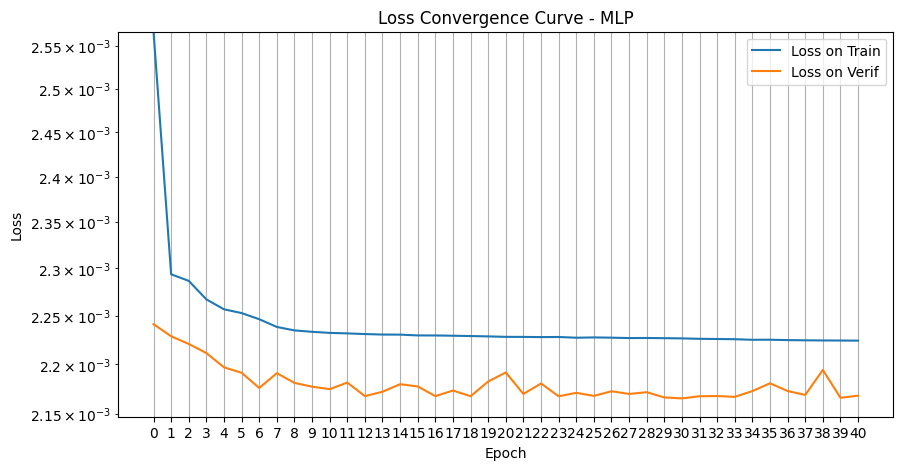

In [7]:

plt.figure(figsize=(10, 5))
plt.plot(epoch_losses_train, label='Loss on Train')
plt.plot(epoch_losses_verif, label='Loss on Verif')
plt.title('Loss Convergence Curve - MLP')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 41, 1))
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0, max(epoch_losses_train))
plt.legend()
plt.grid(True)
plt.savefig('MLP Loss Convergence.pdf', format='pdf')
plt.show()

In [5]:

PPMLP_model = PP_MLP(init_method = 'uniform').to(_device_)
PPMLP_model.load_state_dict(torch.load(model_save_path_MLP))
PPMLP_model.eval()

def denormalize(dataset, model, input):
    outputs = dataset.dataset['outputs']
    min_vals_o = outputs.min(axis=0)  
    max_vals_o = outputs.max(axis=0)         

    range_o = max_vals_o - min_vals_o

    return (model(input)*range_o)+min_vals_o

# dataset.dataset['inputs'][0]

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_34018/1919984327.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PPMLP_model.load_state_dict(torch.load(model_

In [6]:
# Collection of Data

section_len = 10000
section_start = 492500

if (section_start + section_len > len(dataset_test_dn.dataset['outputs'])):
    raise ValueError('Length Overflow: The requested section exceeds the available data size.')

inputs = torch.tensor(dataset_test.dataset['inputs'][section_start:section_start + section_len])

outputs_original = dataset_test_dn.dataset['outputs'][section_start:section_start + section_len].squeeze()
outputs_NN = denormalize(dataset_test_dn, PPMLP_model, inputs).detach().numpy().squeeze()

diffs_in_val = outputs_NN - outputs_original

diffs_in_percent = np.where(outputs_original != 0, 
                            (outputs_NN - outputs_original) / outputs_original * 100, 
                            0)

criterion_no_reduction = nn.MSELoss(reduction='none')
diffs_in_loss = criterion_no_reduction(torch.tensor(outputs_NN, dtype=torch.float32), 
                                       torch.tensor(outputs_original, dtype=torch.float32)).detach().numpy()



In [8]:
inputs

tensor([[0.7559, 0.0000, 0.5627,  ..., 0.3571, 0.3515, 0.3459],
        [0.7561, 1.0000, 0.3728,  ..., 0.3579, 0.3465, 0.3797],
        [0.7577, 0.0000, 0.7563,  ..., 0.3567, 0.3566, 0.5000],
        ...,
        [0.8736, 1.0000, 0.2401,  ..., 0.3879, 0.1544, 0.2143],
        [0.8751, 0.0000, 0.2975,  ..., 0.3892, 0.1538, 0.2519],
        [0.8773, 0.0000, 0.3441,  ..., 0.3730, 0.1609, 0.3158]])

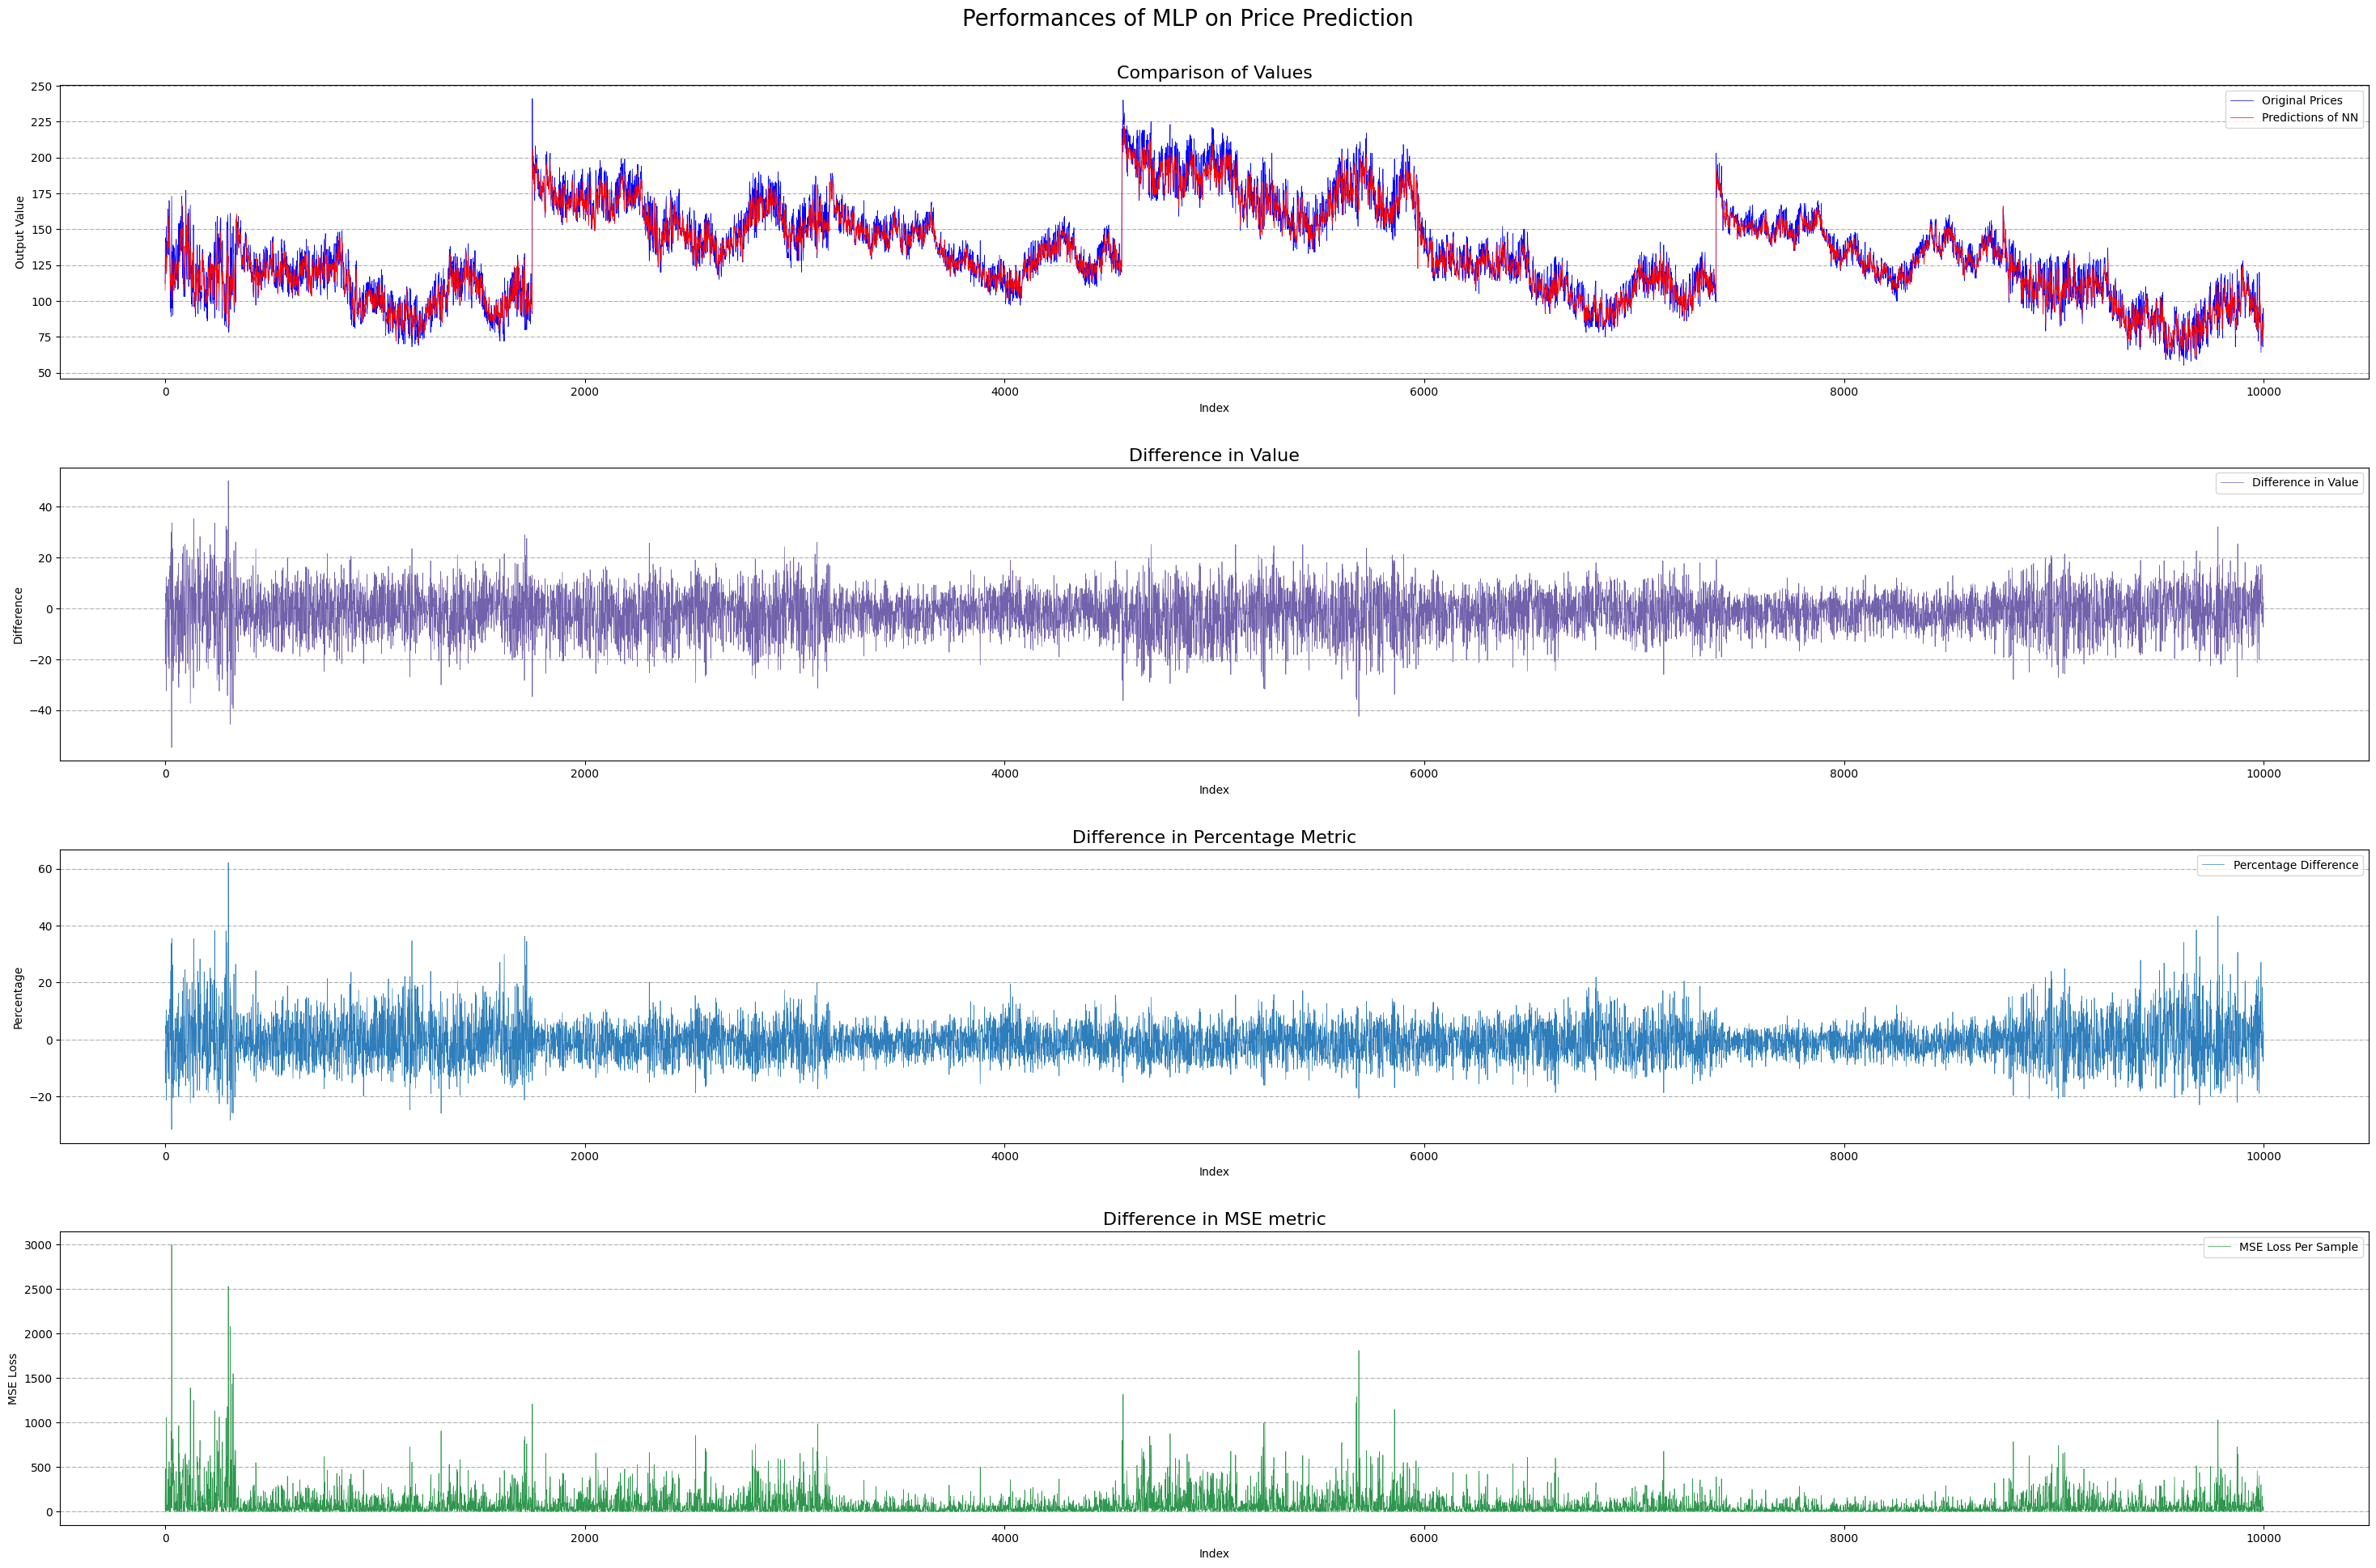

In [7]:

fig, axs = plt.subplots(4, 1, figsize=(30, 20))  


axs[0].plot(outputs_original, label='Original Prices', color='blue',linewidth=0.5)
axs[0].plot(outputs_NN, label='Predictions of NN', color='red',linewidth=0.5)
axs[0].set_title('Comparison of Values',fontsize = 16)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Output Value')
axs[0].legend()

axs[1].plot(diffs_in_val, label='Difference in Value', color='#7262ac',linewidth=0.5)
axs[1].set_title('Difference in Value',fontsize = 16)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Difference')
axs[1].legend()

axs[2].plot(diffs_in_percent, label='Percentage Difference', color='#2e7ebb',linewidth=0.5)
axs[2].set_title('Difference in Percentage Metric', fontsize = 16)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Percentage')
axs[2].legend()

axs[3].plot(diffs_in_loss, label='MSE Loss Per Sample', color='#2e974e',linewidth=0.5)
axs[3].set_title('Difference in MSE metric', fontsize = 16)
axs[3].set_xlabel('Index')
axs[3].set_ylabel('MSE Loss')
axs[3].legend()

for ax_i in axs:
    ax_i.grid(True, axis = 'y', linestyle='-.', linewidth=0.5, color='gray')

plt.suptitle('Performances of MLP on Price Prediction',fontsize = 20)
fig.tight_layout(pad=3.0)
plt.savefig('MLP Performances.pdf', format='pdf')
plt.show()

In [31]:
PPLSTM_model = PP_LSTM(init_method = 'uniform').to(_device_)

loader_train = DataLoader(dataset_train, batch_size=4096, shuffle = True)
loader_verif = DataLoader(dataset_verif, batch_size=4096, shuffle = True)

criterion = nn.MSELoss()
optimizer = optim.Adam(PPLSTM_model.parameters(), lr=0.005)

model_save_path_LSTM = 'PPLSTM_model.pt'
optimizer_save_path_LSTM = 'PPLSTM_optimizer.pt'

In [32]:
# LSTM Training
continue_training = input("Do you want to continue training or start a new one? (c/n): ").lower() == 'c'

if continue_training and os.path.exists(model_save_path_LSTM) and os.path.exists(optimizer_save_path_LSTM):
    
    PPLSTM_model.load_state_dict(torch.load(model_save_path_LSTM))
    optimizer.load_state_dict(torch.load(optimizer_save_path_LSTM))
    
    print("Continuing training from saved state.")
else:
    print("Starting training from scratch.")

epoch_losses_train = []
epoch_losses_verif = []

max_epochs = 100

patience = 10

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

filename = f'LSTM_loss_train & verif_{timestamp}.dat'

with open(filename, 'w') as f:

    best_loss_verif = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):

        PPLSTM_model.train()  

        running_loss_train = 0.0

        print(f"Start epoch {epoch+1}.\n")

        for batch_idx, (inputs, labels) in enumerate(loader_train):
    
            inputs, labels = inputs.to(_device_), labels.to(_device_).unsqueeze(1)
            
            optimizer.zero_grad()

            outputs = PPLSTM_model(inputs.unsqueeze(1))

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss_train += loss.item()

            if ((batch_idx+1) % 500 == 0) or batch_idx == 0:

                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Batch Loss_train: {loss.item()}")

        print('\n')

        PPLSTM_model.eval()

        with torch.no_grad():

            running_loss_verif = 0.0

            for batch_idx, (inputs, labels) in enumerate(loader_verif):

                inputs, labels = inputs.to(_device_), labels.to(_device_).unsqueeze(1)

                outputs = PPLSTM_model(inputs.unsqueeze(1))

                loss = criterion(outputs, labels)

                running_loss_verif += loss.item()

        epoch_loss_train = running_loss_train/len(loader_train)
        epoch_loss_verif = running_loss_verif/len(loader_verif)

        epoch_losses_train.append(epoch_loss_train)
        epoch_losses_verif.append(epoch_loss_verif)

        # scheduler_step.step()

        f.write(f'Epoch {epoch+1}, Loss_train: {epoch_loss_train}, Loss_verif: {epoch_loss_verif}\n')
        print(f'Epoch {epoch+1}, Epoch Average Loss_train: {epoch_loss_train}, Epoch Average Loss_verif: {epoch_loss_verif}\n')

        if epoch_loss_verif < best_loss_verif:
            best_loss_verif = epoch_loss_verif
            patience_counter = 0
            torch.save(PPLSTM_model.state_dict(), model_save_path_LSTM)
            torch.save(optimizer.state_dict(), optimizer_save_path_LSTM)
        else :
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    print('\n')

Starting training from scratch.
Start epoch 1.

Epoch 1, Batch 1, Batch Loss_train: 0.24742689728736877
Epoch 1, Batch 500, Batch Loss_train: 0.008893731981515884
Epoch 1, Batch 1000, Batch Loss_train: 0.00689095351845026
Epoch 1, Batch 1500, Batch Loss_train: 0.006546767894178629
Epoch 1, Batch 2000, Batch Loss_train: 0.006819958332926035
Epoch 1, Batch 2500, Batch Loss_train: 0.0065373945981264114
Epoch 1, Batch 3000, Batch Loss_train: 0.006627771072089672
Epoch 1, Batch 3500, Batch Loss_train: 0.006467744708061218
Epoch 1, Batch 4000, Batch Loss_train: 0.006390899419784546


Epoch 1, Epoch Average Loss_train: 0.007915534945268497, Epoch Average Loss_verif: 0.0046353641374897525

Start epoch 2.

Epoch 2, Batch 1, Batch Loss_train: 0.006287185475230217
Epoch 2, Batch 500, Batch Loss_train: 0.006429392844438553
Epoch 2, Batch 1000, Batch Loss_train: 0.006325263064354658
Epoch 2, Batch 1500, Batch Loss_train: 0.0064015151001513
Epoch 2, Batch 2000, Batch Loss_train: 0.006399489473551512

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1092e1370>>
Traceback (most recent call last):
  File "/Users/ysrae1/MSc_D/env_TraderT/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_99713/2356318604.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, max(epoch_losses_train))


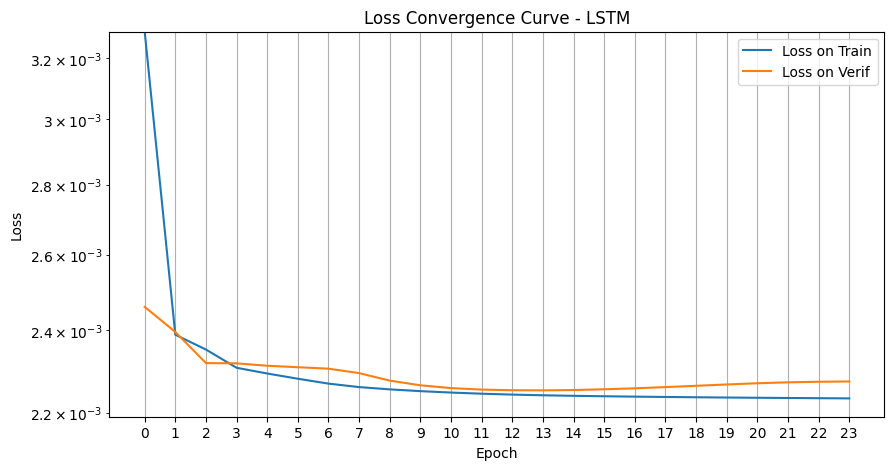

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses_train, label='Loss on Train')
plt.plot(epoch_losses_verif, label='Loss on Verif')
plt.title('Loss Convergence Curve - LSTM')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0, max(epoch_losses_train))
plt.legend()
plt.grid(True)
plt.savefig('LSTM Loss Convergence.pdf', format='pdf')
plt.show()

In [51]:
PPLSTM_model = PP_LSTM(init_method = 'uniform').to(_device_)
PPLSTM_model.load_state_dict(torch.load(model_save_path_LSTM))
PPLSTM_model.eval()

PP_LSTM(
  (lstm): LSTM(13, 10, batch_first=True)
  (dense_1): Linear(in_features=10, out_features=5, bias=True)
  (dense_2): Linear(in_features=5, out_features=3, bias=True)
  (dense_3): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
# Collection of Data

section_len = 5000
section_start = 500000

if (section_start + section_len > len(dataset_test_dn.dataset['outputs'])):
    raise ValueError('Length Overflow: The requested section exceeds the available data size.')

inputs = torch.tensor(dataset_test.dataset['inputs'][section_start:section_start + section_len])

outputs_original = dataset_test_dn.dataset['outputs'][section_start:section_start + section_len].squeeze()
outputs_NN = denormalize(dataset_test_dn, PPLSTM_model, inputs.unsqueeze(1)).detach().numpy().squeeze()

diffs_in_val = outputs_NN - outputs_original

diffs_in_percent = np.where(outputs_original != 0, 
                            (outputs_NN - outputs_original) / outputs_original * 100, 
                            0)

criterion_no_reduction = nn.MSELoss(reduction='none')
diffs_in_loss = criterion_no_reduction(torch.tensor(outputs_NN, dtype=torch.float32), 
                                       torch.tensor(outputs_original, dtype=torch.float32)).detach().numpy()



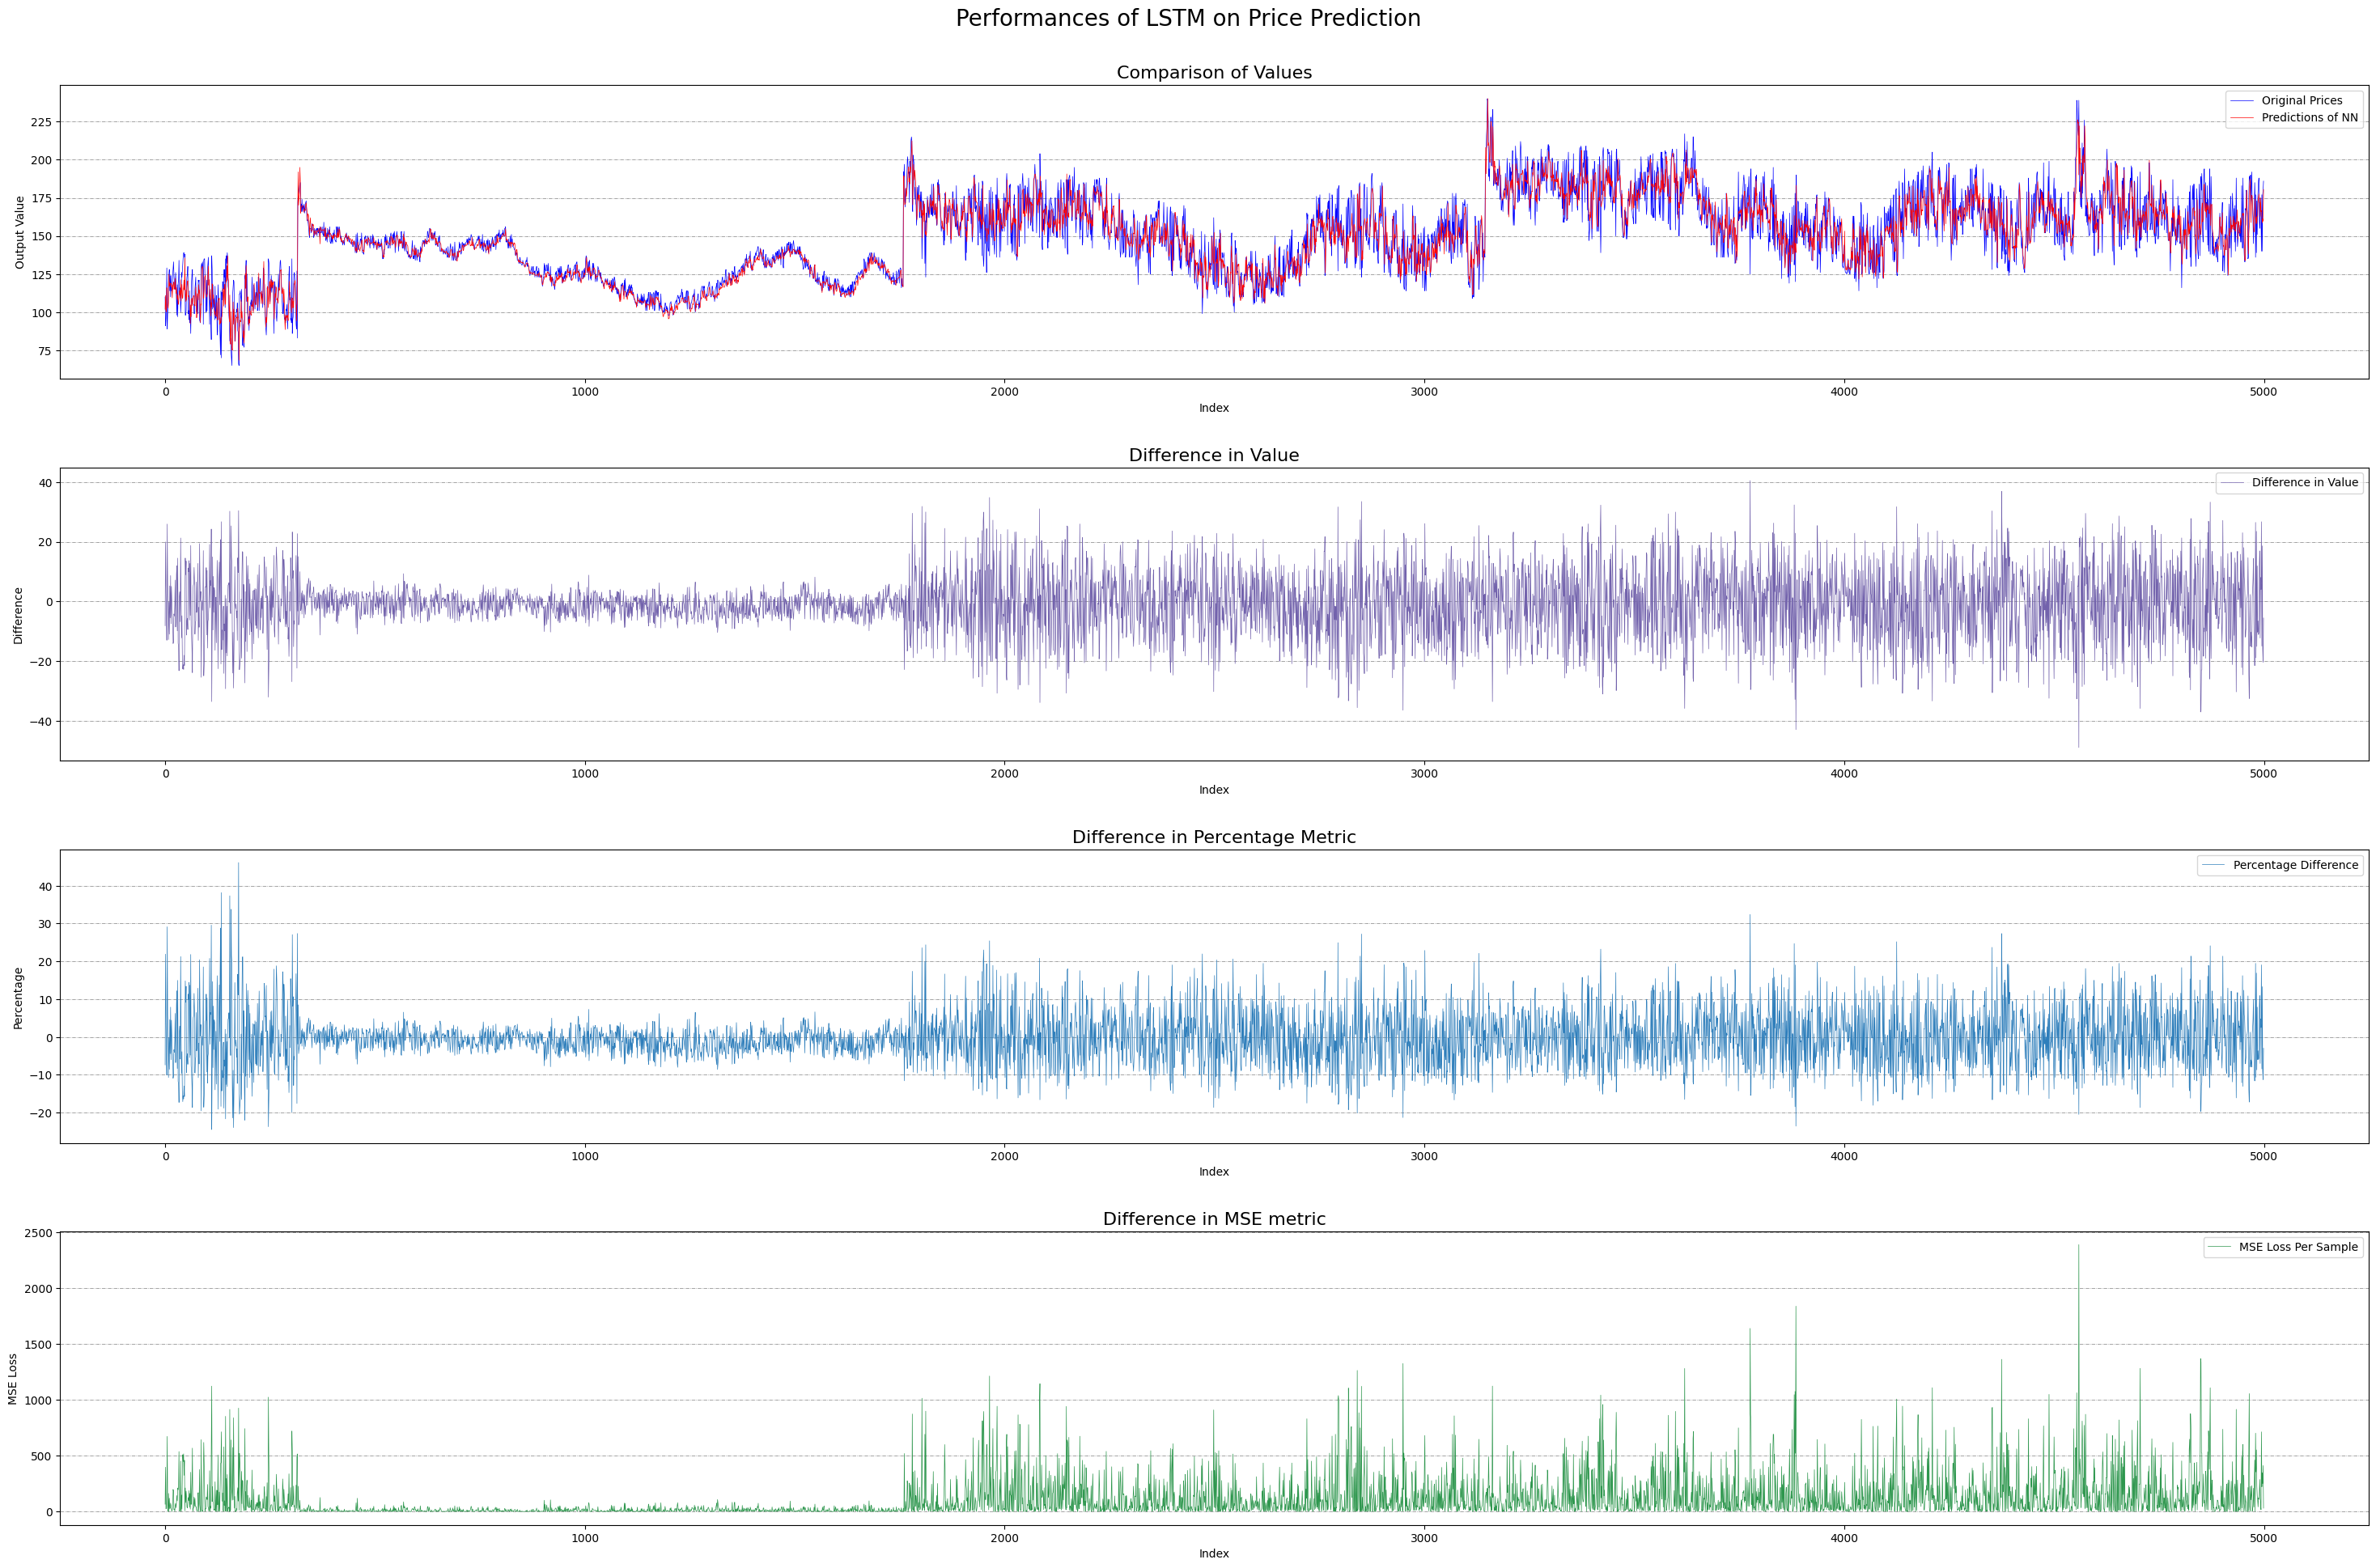

In [54]:

fig, axs = plt.subplots(4, 1, figsize=(30, 20))  


axs[0].plot(outputs_original, label='Original Prices', color='blue',linewidth=0.5)
axs[0].plot(outputs_NN, label='Predictions of NN', color='red',linewidth=0.5)
axs[0].set_title('Comparison of Values',fontsize = 16)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Output Value')
axs[0].legend()

axs[1].plot(diffs_in_val, label='Difference in Value', color='#7262ac',linewidth=0.5)
axs[1].set_title('Difference in Value',fontsize = 16)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Difference')
axs[1].legend()

axs[2].plot(diffs_in_percent, label='Percentage Difference', color='#2e7ebb',linewidth=0.5)
axs[2].set_title('Difference in Percentage Metric', fontsize = 16)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Percentage')
axs[2].legend()

axs[3].plot(diffs_in_loss, label='MSE Loss Per Sample', color='#2e974e',linewidth=0.5)
axs[3].set_title('Difference in MSE metric', fontsize = 16)
axs[3].set_xlabel('Index')
axs[3].set_ylabel('MSE Loss')
axs[3].legend()

for ax_i in axs:
    ax_i.grid(True, axis = 'y', linestyle='-.', linewidth=0.5, color='gray')

plt.suptitle('Performances of LSTM on Price Prediction',fontsize = 20)
fig.tight_layout(pad=3.0)
plt.savefig('LSTM Performances.pdf', format='pdf')
plt.show()